In [1]:

import os
import numpy as np
import pandas as pd


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Flatten
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from tensorflow.keras.metrics import AUC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.models import load_model



import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import seaborn as sns
from itertools import cycle


In [ ]:
# Define defaults

# Set seed for NumPy
np.random.seed(42)

FILENAME = "../../datasets/BCCC-CIC-IDS-2017/subsets/training_v1.csv"
FILENAME_TEST = "../../datasets/BCCC-CIC-IDS-2017/subsets/test_v1.csv"

In [3]:
# Load csv file
df = pd.read_csv(FILENAME, low_memory=False)
df_test = pd.read_csv(FILENAME_TEST, low_memory=False)

In [4]:
X_train = df.drop("label", axis=1)
y_train = df["label"]


X_test = df_test.drop("label", axis=1)
y_test = df_test["label"]

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [6]:
y_train.value_counts()

label
0    328438
3    127418
1     42573
2      3460
4      2537
5      2093
Name: count, dtype: int64

In [7]:
y_train.shape

(506519,)

In [8]:
y_test.value_counts()

label
0    365427
3    141203
1     47234
2      3863
4      2739
5      2334
Name: count, dtype: int64

In [9]:
y_test.shape

(562800,)

In [10]:
# Prepration for Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
columns_to_normalize = X_train.columns.tolist()

In [11]:
columns_to_normalize

['fwd_rst_flag_counts',
 'rst_flag_counts',
 'bwd_avg_segment_size',
 'bwd_payload_bytes_variance',
 'payload_bytes_std',
 'bwd_payload_bytes_std',
 'fwd_payload_bytes_std',
 'payload_bytes_variance',
 'payload_bytes_mean',
 'fwd_payload_bytes_mean',
 'bwd_payload_bytes_mean',
 'avg_segment_size',
 'payload_bytes_max',
 'fwd_payload_bytes_max',
 'bwd_payload_bytes_max',
 'packet_IAT_min',
 'packets_IAT_mean',
 'packet_IAT_max',
 'packet_IAT_total',
 'fwd_packets_IAT_min',
 'fwd_packets_IAT_mean',
 'fwd_packets_IAT_total',
 'fwd_packets_IAT_max',
 'bwd_std_header_bytes',
 'active_std',
 'idle_min',
 'idle_mean',
 'idle_max',
 'bwd_rst_flag_counts',
 'fwd_std_header_bytes',
 'std_header_bytes',
 'fwd_syn_flag_counts',
 'bwd_init_win_bytes',
 'bwd_fin_flag_counts',
 'fwd_packets_IAT_std',
 'fwd_init_win_bytes',
 'bwd_packets_IAT_min',
 'bwd_packets_IAT_mean',
 'bwd_packets_IAT_max',
 'bwd_packets_IAT_total',
 'bwd_max_header_bytes',
 'packet_IAT_std',
 'syn_flag_counts',
 'bwd_bytes_rate'

In [12]:
# Configuration for Cross Validation
kf = KFold(n_splits=5)
rus = RandomUnderSampler(random_state=42, sampling_strategy='auto')
seq_length = 1  # Number of time steps per sequence
mlb = MultiLabelBinarizer(classes=range(6))  # Specify the classes if needed (in this case, 6 labels)
histories = []
predictions = []

In [13]:
# ## Convert data into mlp-friendly format
X_test = X_test.to_numpy().reshape((X_test.shape[0], 1, X_test.shape[1]))
y_test_binary = mlb.fit_transform(y_test.to_numpy().reshape(-1, 1))

In [14]:
for i, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    print(f"Fold {i + 1}:")
    print(f"  Train: index={train_index}")
    print(f"  Val:  index={val_index}")
    
    
    lstm = Sequential([
    Input(shape=(1, len(columns_to_normalize))),  # Now (timesteps=1, features)
    Flatten(),
    Dense(140, activation="relu", kernel_initializer='lecun_uniform'),
    Dense(120, activation="relu", kernel_initializer='lecun_uniform'),
    Dense(100, activation="relu", kernel_initializer='lecun_uniform'),
    Dense(80, activation="relu", kernel_initializer='lecun_uniform'),
    Dense(60, activation="relu", kernel_initializer='lecun_uniform'),
    Dense(40, activation="relu", kernel_initializer='lecun_uniform'),
    Dense(20, activation="relu", kernel_initializer='lecun_uniform'),
    Dense(120, activation="relu", kernel_initializer='lecun_uniform'),
    Dense(6, activation="softmax", kernel_initializer='glorot_uniform')
    ])

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    lstm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['categorical_accuracy'])
        
    # training
    X_fold_training = X_train.iloc[train_index]
    y_fold_training = y_train.iloc[train_index]
    
    # Normalize
    X_fold_training[columns_to_normalize] = scaler.fit_transform(X_fold_training[columns_to_normalize])
    
    # RUS
    X_fold_training, y_fold_training = rus.fit_resample(X_fold_training, y_fold_training)
    

    # print(f"Label distribution Training:\n")
    # print(y_fold_training.value_counts())
    
    # validation
    X_fold_val = X_train.iloc[val_index]
    y_fold_val = y_train.iloc[val_index]
    
    # Normalize
    X_fold_val[columns_to_normalize] = scaler.fit_transform(X_fold_val[columns_to_normalize])
    
    # RUS
    X_fold_val, y_fold_val = rus.fit_resample(X_fold_val, y_fold_val)
    
    
    # print(f"\nLabel distribution Validation:\n")
    # print(y_fold_val.value_counts())
    
    
    # Convert data into LSTM-friendly format
    X_train_lstm, y_train_lstm = [], []
    X_val_lstm, y_val_lstm = [], []
    
    # training
    X_train_lstm = X_fold_training.to_numpy().reshape((X_fold_training.shape[0], 1, X_fold_training.shape[1]))
    # for i in range(len(X_fold_training) - seq_length):
    #     X_train_lstm.append(X_fold_training[i : i + seq_length])
    #     y_train_lstm.append(y_fold_training.iloc[i + seq_length])
    
    # validation
    X_val_lstm = X_fold_val.to_numpy().reshape((X_fold_val.shape[0], 1, X_fold_val.shape[1]))
    # for i in range(len(X_fold_val) - seq_length):
    #     X_val_lstm.append(X_fold_val[i : i + seq_length])
    #     y_val_lstm.append(y_fold_val.iloc[i + seq_length])
    
    # X_train_lstm, y_train_lstm = np.array(X_train_lstm), np.array(y_train_lstm)
    # X_val_lstm, y_val_lstm = np.array(X_val_lstm), np.array(y_val_lstm)
    
    # Convert y_train, y_test and y_val to MultiLabel binaries
    y_train_binary = mlb.fit_transform(y_fold_training.to_numpy().reshape(-1, 1))
    y_val_binary = mlb.fit_transform(y_fold_val.to_numpy().reshape(-1, 1))
    
    # y_train_binary = mlb.fit_transform(y_train_lstm.reshape(-1, 1))
    # y_val_binary = mlb.fit_transform(y_val_lstm.reshape(-1, 1))
    
    # Train Model
    history = lstm.fit(X_train_lstm, y_train_binary, epochs=100, batch_size=32, validation_data=(X_val_lstm, y_val_binary))
    histories.append(history)
    
    # Classify using the Test dataset
    y_pred = (lstm.predict(X_test) > 0.5).astype("int32")
    predictions.append(y_pred)
    
    # print(classification_report(y_test_binary, y_pred, zero_division=0))
    # print(f"Accuracy: {accuracy_score(y_test_binary, y_pred):.4f}")


Fold 1:
  Train: index=[101304 101305 101306 ... 506516 506517 506518]
  Val:  index=[     0      1      2 ... 101301 101302 101303]


/var/folders/qg/czgp8gyn3057jghb1vm_44yr0000gp/T/ipykernel_27255/140643231.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_fold_training[columns_to_normalize] = scaler.fit_transform(X_fold_training[columns_to_normalize])


Epoch 1/100


/var/folders/qg/czgp8gyn3057jghb1vm_44yr0000gp/T/ipykernel_27255/140643231.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_fold_val[columns_to_normalize] = scaler.fit_transform(X_fold_val[columns_to_normalize])


311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - categorical_accuracy: 0.6039 - loss: 0.9903 - val_categorical_accuracy: 0.8406 - val_loss: 0.4496
Epoch 2/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8729 - loss: 0.3585 - val_categorical_accuracy: 0.8770 - val_loss: 0.3258
Epoch 3/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8901 - loss: 0.3062 - val_categorical_accuracy: 0.9061 - val_loss: 0.2703
Epoch 4/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8875 - loss: 0.3030 - val_categorical_accuracy: 0.8893 - val_loss: 0.2995
Epoch 5/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8997 - loss: 0.2718 - val_categorical_accuracy: 0.9065 - val_loss: 0.2590
Epoch 6/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9046 - loss: 0.2539 - val_categorical_accuracy: 0.9123 - val_loss: 0.2372
Epoch 7/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9026 - loss: 0.

/var/folders/qg/czgp8gyn3057jghb1vm_44yr0000gp/T/ipykernel_27255/140643231.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_fold_training[columns_to_normalize] = scaler.fit_transform(X_fold_training[columns_to_normalize])
/var/folders/qg/czgp8gyn3057jghb1vm_44yr0000gp/T/ipykernel_27255/140643231.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_fold_val[columns_to_normalize] = scaler.fit_transform(X_fold_val[columns_to_normalize])


Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - categorical_accuracy: 0.5522 - loss: 1.0562 - val_categorical_accuracy: 0.8688 - val_loss: 0.3602
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8765 - loss: 0.3418 - val_categorical_accuracy: 0.8797 - val_loss: 0.2961
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8782 - loss: 0.3215 - val_categorical_accuracy: 0.8882 - val_loss: 0.3010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - categorical_accuracy: 0.8940 - loss: 0.2881 - val_categorical_accuracy: 0.8403 - val_loss: 0.3529
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9005 - loss: 0.2770 - val_categorical_accuracy: 0.8898 - val_loss: 0.2934
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9044 - loss: 0.2496 - val_categorical_accuracy: 0.8988 - val_loss: 0.2600
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9

/var/folders/qg/czgp8gyn3057jghb1vm_44yr0000gp/T/ipykernel_27255/140643231.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_fold_training[columns_to_normalize] = scaler.fit_transform(X_fold_training[columns_to_normalize])


Epoch 1/100


/var/folders/qg/czgp8gyn3057jghb1vm_44yr0000gp/T/ipykernel_27255/140643231.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_fold_val[columns_to_normalize] = scaler.fit_transform(X_fold_val[columns_to_normalize])


311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - categorical_accuracy: 0.5948 - loss: 1.0196 - val_categorical_accuracy: 0.8782 - val_loss: 0.3632
Epoch 2/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8782 - loss: 0.3431 - val_categorical_accuracy: 0.8169 - val_loss: 0.4975
Epoch 3/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8967 - loss: 0.2805 - val_categorical_accuracy: 0.8793 - val_loss: 0.3269
Epoch 4/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8960 - loss: 0.2762 - val_categorical_accuracy: 0.8801 - val_loss: 0.3085
Epoch 5/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8988 - loss: 0.2724 - val_categorical_accuracy: 0.8739 - val_loss: 0.3389
Epoch 6/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - categorical_accuracy: 0.9071 - loss: 0.2397 - val_categorical_accuracy: 0.8778 - val_loss: 0.3655
Epoch 7/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9044 - loss: 

/var/folders/qg/czgp8gyn3057jghb1vm_44yr0000gp/T/ipykernel_27255/140643231.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_fold_training[columns_to_normalize] = scaler.fit_transform(X_fold_training[columns_to_normalize])


Epoch 1/100


/var/folders/qg/czgp8gyn3057jghb1vm_44yr0000gp/T/ipykernel_27255/140643231.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_fold_val[columns_to_normalize] = scaler.fit_transform(X_fold_val[columns_to_normalize])


322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - categorical_accuracy: 0.5624 - loss: 1.0355 - val_categorical_accuracy: 0.8807 - val_loss: 0.3476
Epoch 2/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - categorical_accuracy: 0.8677 - loss: 0.3518 - val_categorical_accuracy: 0.9088 - val_loss: 0.2584
Epoch 3/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - categorical_accuracy: 0.9007 - loss: 0.2777 - val_categorical_accuracy: 0.8952 - val_loss: 0.2679
Epoch 4/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - categorical_accuracy: 0.8964 - loss: 0.2764 - val_categorical_accuracy: 0.8803 - val_loss: 0.3155
Epoch 5/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - categorical_accuracy: 0.8994 - loss: 0.2565 - val_categorical_accuracy: 0.9110 - val_loss: 0.2449
Epoch 6/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - categorical_accuracy: 0.9048 - loss: 0.2481 - val_categorical_accuracy: 0.9123 - val_loss: 0.2479
Epoch 7/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - categorical_accuracy: 0.905

/var/folders/qg/czgp8gyn3057jghb1vm_44yr0000gp/T/ipykernel_27255/140643231.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_fold_training[columns_to_normalize] = scaler.fit_transform(X_fold_training[columns_to_normalize])
/var/folders/qg/czgp8gyn3057jghb1vm_44yr0000gp/T/ipykernel_27255/140643231.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_fold_val[columns_to_normalize] = scaler.fit_transform(X_fold_val[columns_to_normalize])


Epoch 1/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - categorical_accuracy: 0.5404 - loss: 1.0750 - val_categorical_accuracy: 0.7293 - val_loss: 0.9523
Epoch 2/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - categorical_accuracy: 0.8817 - loss: 0.3446 - val_categorical_accuracy: 0.8317 - val_loss: 0.4531
Epoch 3/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - categorical_accuracy: 0.8915 - loss: 0.2851 - val_categorical_accuracy: 0.8060 - val_loss: 0.6099
Epoch 4/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - categorical_accuracy: 0.8910 - loss: 0.3033 - val_categorical_accuracy: 0.7908 - val_loss: 0.6500
Epoch 5/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - categorical_accuracy: 0.8938 - loss: 0.2636 - val_categorical_accuracy: 0.7972 - val_loss: 0.7138
Epoch 6/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - categorical_accuracy: 0.9046 - loss: 0.2475 - val_categorical_accuracy: 0.7827 - val_loss: 0.8100
Epoch 7/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accur

In [15]:
metric_names = list(histories[0].history.keys())
avg_metrics = {metric: [] for metric in metric_names}

# Compute mean per epoch across folds
for metric in metric_names:
    avg_metrics[metric] = np.mean([fold.history[metric] for fold in histories], axis=0)

# Print average metrics
for metric, values in avg_metrics.items():
    print(f"Average {metric}: {values[-1]:.4f}")  # Showing the last epoch's value

Average categorical_accuracy: 0.9185
Average loss: 0.2047
Average val_categorical_accuracy: 0.9092
Average val_loss: 0.2729


In [16]:
threshold = 0.5
avg_predictions = np.mean(predictions, axis=0)  # Mean ensemble
y_pred_binary = (avg_predictions >= threshold).astype(int)


In [17]:

print(classification_report(y_test_binary, y_pred_binary, zero_division=0, digits=4))


              precision    recall  f1-score   support

           0     0.9996    0.8420    0.9141    365427
           1     0.9990    0.9993    0.9991     47234
           2     0.4665    0.9599    0.6279      3863
           3     0.7418    0.9966    0.8505    141203
           4     0.6669    0.7996    0.7272      2739
           5     0.8769    0.8115    0.8429      2334

   micro avg     0.9019    0.8945    0.8982    562800
   macro avg     0.7918    0.9015    0.8270    562800
weighted avg     0.9291    0.8945    0.9021    562800
 samples avg     0.8945    0.8945    0.8945    562800



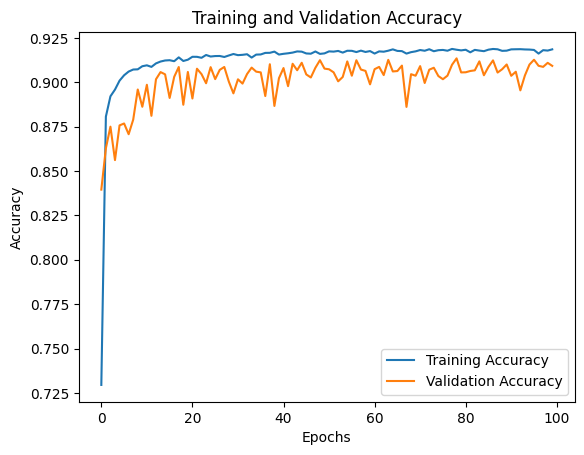

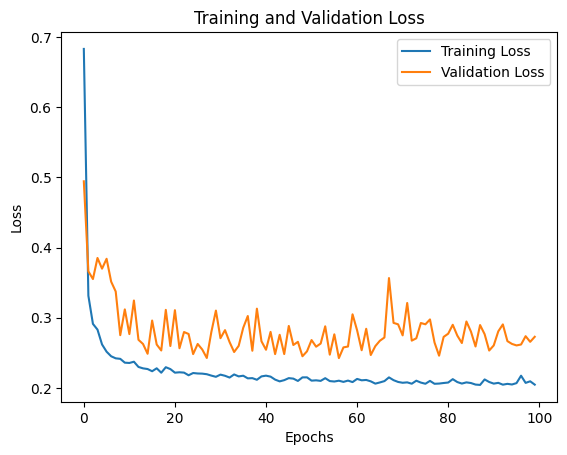

In [18]:
# Plot loss and accuraccy of training

# Plot accuracy
plt.plot(avg_metrics['categorical_accuracy'], label='Training Accuracy')
plt.plot(avg_metrics['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(avg_metrics['loss'], label='Training Loss')
plt.plot(avg_metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

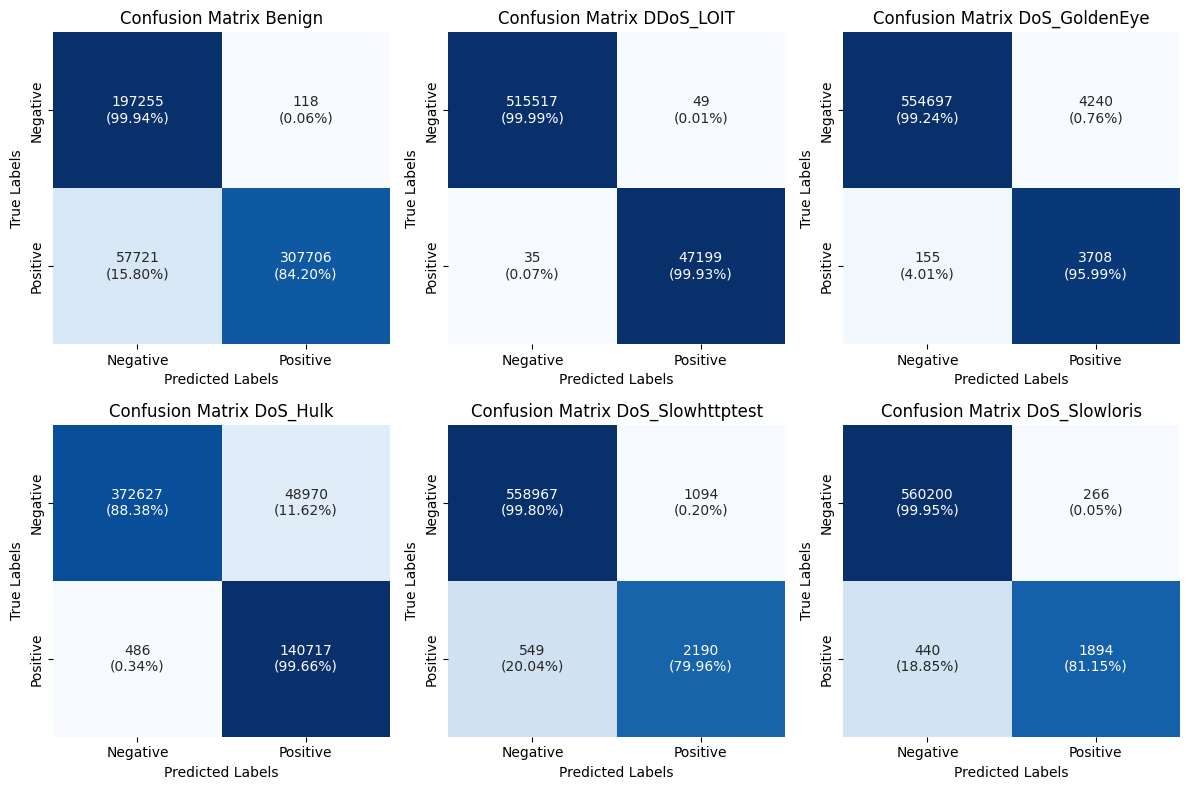

In [19]:
# Compute multilabel confusion matrix
mcm = multilabel_confusion_matrix(y_test_binary, y_pred_binary)

attack_labels = ["Benign", "DDoS_LOIT", "DoS_GoldenEye", "DoS_Hulk", "DoS_Slowhttptest", "DoS_Slowloris"]

# Set up the plot
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Plot each confusion matrix as a heatmap
for i, ax in enumerate(axes.flat):
    cm = mcm[i]
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Normalize by row (True Labels)
    
    # Annotate with both raw count and percentage
    annotations = []
    for j in range(cm.shape[0]):  # Loop through each row
        row_annotations = []
        for k in range(cm.shape[1]):  # Loop through each column
            count = cm[j, k]
            percentage = cm_percent[j, k]
            row_annotations.append(f'{count}\n({percentage:.2f}%)')
        annotations.append(row_annotations)
    
    # Plot the confusion matrix with both numbers and percentages
    sns.heatmap(cm_percent, annot=annotations, fmt='', cmap='Blues', cbar=False, ax=ax, 
                annot_kws={"size": 10}, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    
    ax.set_title(f'Confusion Matrix {attack_labels[i]}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

plt.tight_layout()
plt.show()

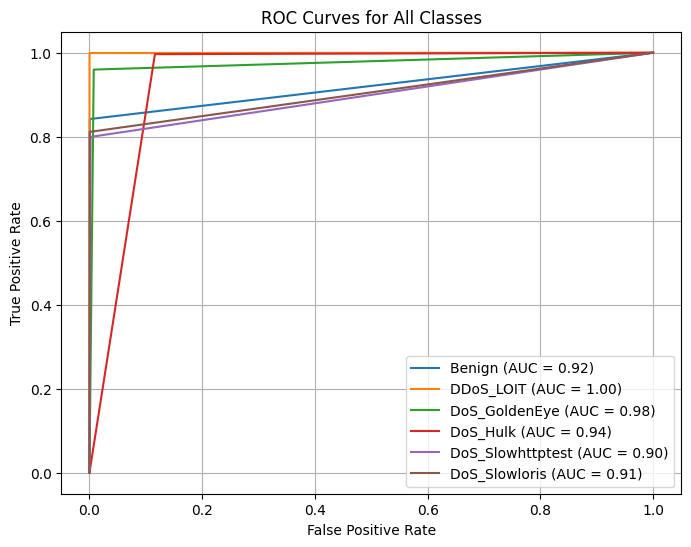

In [20]:
# Number of classes
n_classes = y_test_binary.shape[1]
labels = ["Benign", "DDoS_LOIT", "DoS_GoldenEye", "DoS_Hulk", "DoS_Slowhttptest", "DoS_Slowloris"]

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binary[:, i], y_pred_binary[:, i])
    roc_auc = auc(fpr, tpr)  # Compute AUC
    plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

# Plot random classifier (diagonal line)
# plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

# Formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Classes')
plt.legend()
plt.grid()
plt.show()

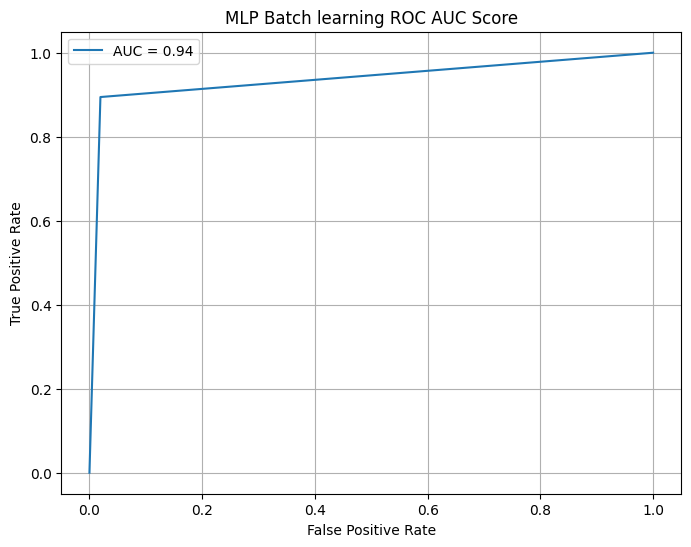

In [21]:
# Compute micro-average ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_binary.ravel(), y_pred_binary.ravel())
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
# Plot random classifier
# plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

# Formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP Batch learning ROC AUC Score')
plt.legend()
plt.grid()
plt.show()

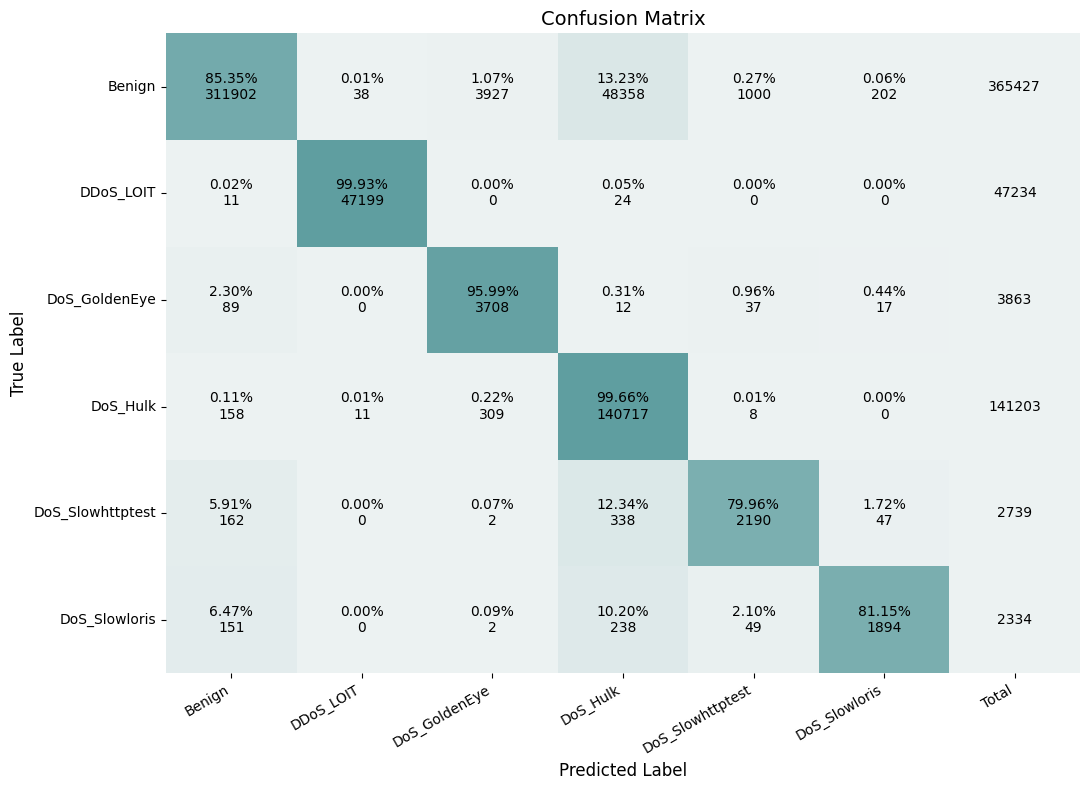

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert one-hot to class indices
y_true = np.argmax(y_test_binary, axis=1)
y_pred = np.argmax(y_pred_binary, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
row_totals = cm.sum(axis=1)
cm_percent = cm.astype('float') / row_totals[:, np.newaxis] * 100

# Add a new column with zeros for the "Total" column (for coloring)
cm_percent_extended = np.hstack([cm_percent, np.zeros((cm_percent.shape[0], 1))])

# Create extended annotations with Total
annotations = np.empty_like(cm_percent_extended).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_percent[i, j]
        annotations[i, j] = f"{percent:.2f}%\n{count}"
    # Add total count annotation to last column
    annotations[i, -1] = f"{row_totals[i]}"

# Updated labels
attack_labels = ["Benign", "DDoS_LOIT", "DoS_GoldenEye", "DoS_Hulk", "DoS_Slowhttptest", "DoS_Slowloris"]
xtick_labels = attack_labels + ["Total"]

# Set up the plot
plt.figure(figsize=(11, 8))  # Slightly wider for the extra column

# Use matching light cyan/blue color map
cmap = sns.light_palette("cadetblue", as_cmap=True)

# Plot heatmap
sns.heatmap(cm_percent_extended, annot=annotations, fmt='', cmap=cmap, cbar=False,
            xticklabels=xtick_labels, yticklabels=attack_labels,
            annot_kws={"size": 10, "color": "black"})

# Formatting
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()
